CELL 1: IMPORTS & SETUP

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support

# Configuration
DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
EPOCHS = 15
SEED = 42

# Global storage for results comparison
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

CELL 2: DATASET CLASS

In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

CELL 3: TRAINING ENGINE (WITH HISTORY TRACKING)

In [ ]:
def train_and_evaluate_with_history(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    best_acc = 0.0
    
    print(f"\n--- Training {model_name} ---")
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        history['train_acc'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_correct = 0; val_total = 0; val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = val_loss / len(test_loader)
        history['val_acc'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.1f}% | Val Acc: {epoch_val_acc:.1f}%")
            
        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(DATASET_ROOT, f'{model_name}_best.pth'))
            
    return history, best_acc

CELL 4: STAGE 1 - RAW DATA (BASELINE)

In [ ]:
print("--- STAGE 1: DENSENET121 RAW DATA (Baseline) ---")

# 1. Basic Transform (Raw Data - Only Resize & Normalize)
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Setup Data
dataset_basic = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset_basic)))
split = int(np.floor(0.2 * len(dataset_basic)))
np.random.seed(SEED)
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])

train_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_basic = DataLoader(dataset_basic, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Load DenseNet121 (Pre-trained)
model_densenet_basic = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
# Freeze early layers to save memory
for param in model_densenet_basic.features.parameters():
    param.requires_grad = False
# Change classifier for 2 classes
num_ftrs = model_densenet_basic.classifier.in_features
model_densenet_basic.classifier = nn.Linear(num_ftrs, 2)

# 4. Train Baseline
history_basic, acc_basic = train_and_evaluate_with_history(model_densenet_basic, train_loader_basic, test_loader_basic, EPOCHS, "densenet121_raw")
results['1. Raw Data'] = acc_basic

CELL 5: STAGE 2 - AUGMENTED DATA (IMPROVED)

In [ ]:
print("\n--- STAGE 2: DENSENET121 AUGMENTED DATA ---")

# 1. Augmented Transform
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Setup Data (Use SAME split indices for fair comparison)
dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

# 3. Load Fresh DenseNet121
model_densenet_aug = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
for param in model_densenet_aug.features.parameters():
    param.requires_grad = False
num_ftrs = model_densenet_aug.classifier.in_features
model_densenet_aug.classifier = nn.Linear(num_ftrs, 2)

# 4. Train Augmented Model
history_aug, acc_aug = train_and_evaluate_with_history(model_densenet_aug, train_loader_aug, test_loader_aug, EPOCHS, "densenet121_augmented")
results['2. Augmented Data'] = acc_aug

CELL 6: STAGE 3 - 5-FOLD CROSS-VALIDATION

In [7]:
print("\n--- STAGE 3: 5-FOLD CROSS-VALIDATION ---")

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_accuracies = []
fold = 1

# Use augmented dataset for cross-validation
dataset_cv = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

for train_idx, val_idx in kf.split(dataset_cv):
    print(f"\n--- Fold {fold}/5 ---")
    
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)
    
    train_loader_cv = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=train_subsampler)
    val_loader_cv = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    # Fresh model for each fold
    model_cv = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    for param in model_cv.features.parameters():
        param.requires_grad = False
    num_ftrs = model_cv.classifier.in_features
    model_cv.classifier = nn.Linear(num_ftrs, 2)
    model_cv = model_cv.to(device)
    
    # Train (reduced epochs for CV speed)
    _, fold_acc = train_and_evaluate_with_history(model_cv, train_loader_cv, val_loader_cv, 10, f"densenet121_fold{fold}")
    cv_accuracies.append(fold_acc)
    
    print(f"Fold {fold} Accuracy: {fold_acc:.2f}%")
    
    # Clear GPU memory after each fold
    del model_cv
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    fold += 1

# Calculate statistics
avg_cv_acc = np.mean(cv_accuracies)
std_cv_acc = np.std(cv_accuracies)
results['3. Cross-Validation (Avg)'] = avg_cv_acc

print(f"\n=== 5-FOLD CV RESULTS ===")
print(f"Individual Fold Accuracies: {[f'{acc:.2f}%' for acc in cv_accuracies]}")
print(f"Mean Accuracy: {avg_cv_acc:.2f}%")
print(f"Standard Deviation: {std_cv_acc:.2f}%")


--- STAGE 3: 5-FOLD CROSS-VALIDATION ---

--- Fold 1/5 ---

--- Training densenet121_fold1 ---
Epoch 1/10 | Train Acc: 72.9% | Val Acc: 76.7%
Epoch 2/10 | Train Acc: 74.0% | Val Acc: 78.0%
Epoch 3/10 | Train Acc: 75.7% | Val Acc: 78.7%
Epoch 4/10 | Train Acc: 77.7% | Val Acc: 80.0%
Epoch 5/10 | Train Acc: 80.7% | Val Acc: 80.7%
Epoch 6/10 | Train Acc: 79.1% | Val Acc: 88.0%
Epoch 7/10 | Train Acc: 86.1% | Val Acc: 84.0%
Epoch 8/10 | Train Acc: 84.1% | Val Acc: 90.7%
Epoch 9/10 | Train Acc: 85.9% | Val Acc: 86.0%
Epoch 10/10 | Train Acc: 86.4% | Val Acc: 93.3%
Fold 1 Accuracy: 93.33%

--- Fold 2/5 ---

--- Training densenet121_fold2 ---
Epoch 1/10 | Train Acc: 72.5% | Val Acc: 76.0%
Epoch 2/10 | Train Acc: 72.7% | Val Acc: 79.3%
Epoch 3/10 | Train Acc: 74.2% | Val Acc: 80.7%
Epoch 4/10 | Train Acc: 76.9% | Val Acc: 84.0%
Epoch 5/10 | Train Acc: 78.7% | Val Acc: 88.7%
Epoch 6/10 | Train Acc: 81.4% | Val Acc: 87.3%
Epoch 7/10 | Train Acc: 81.4% | Val Acc: 87.3%
Epoch 8/10 | Train Acc: 84

CELL 7: COMPREHENSIVE VISUALIZATION & METRICS

=== GENERATING DENSENET121 COMPREHENSIVE REPORT ===


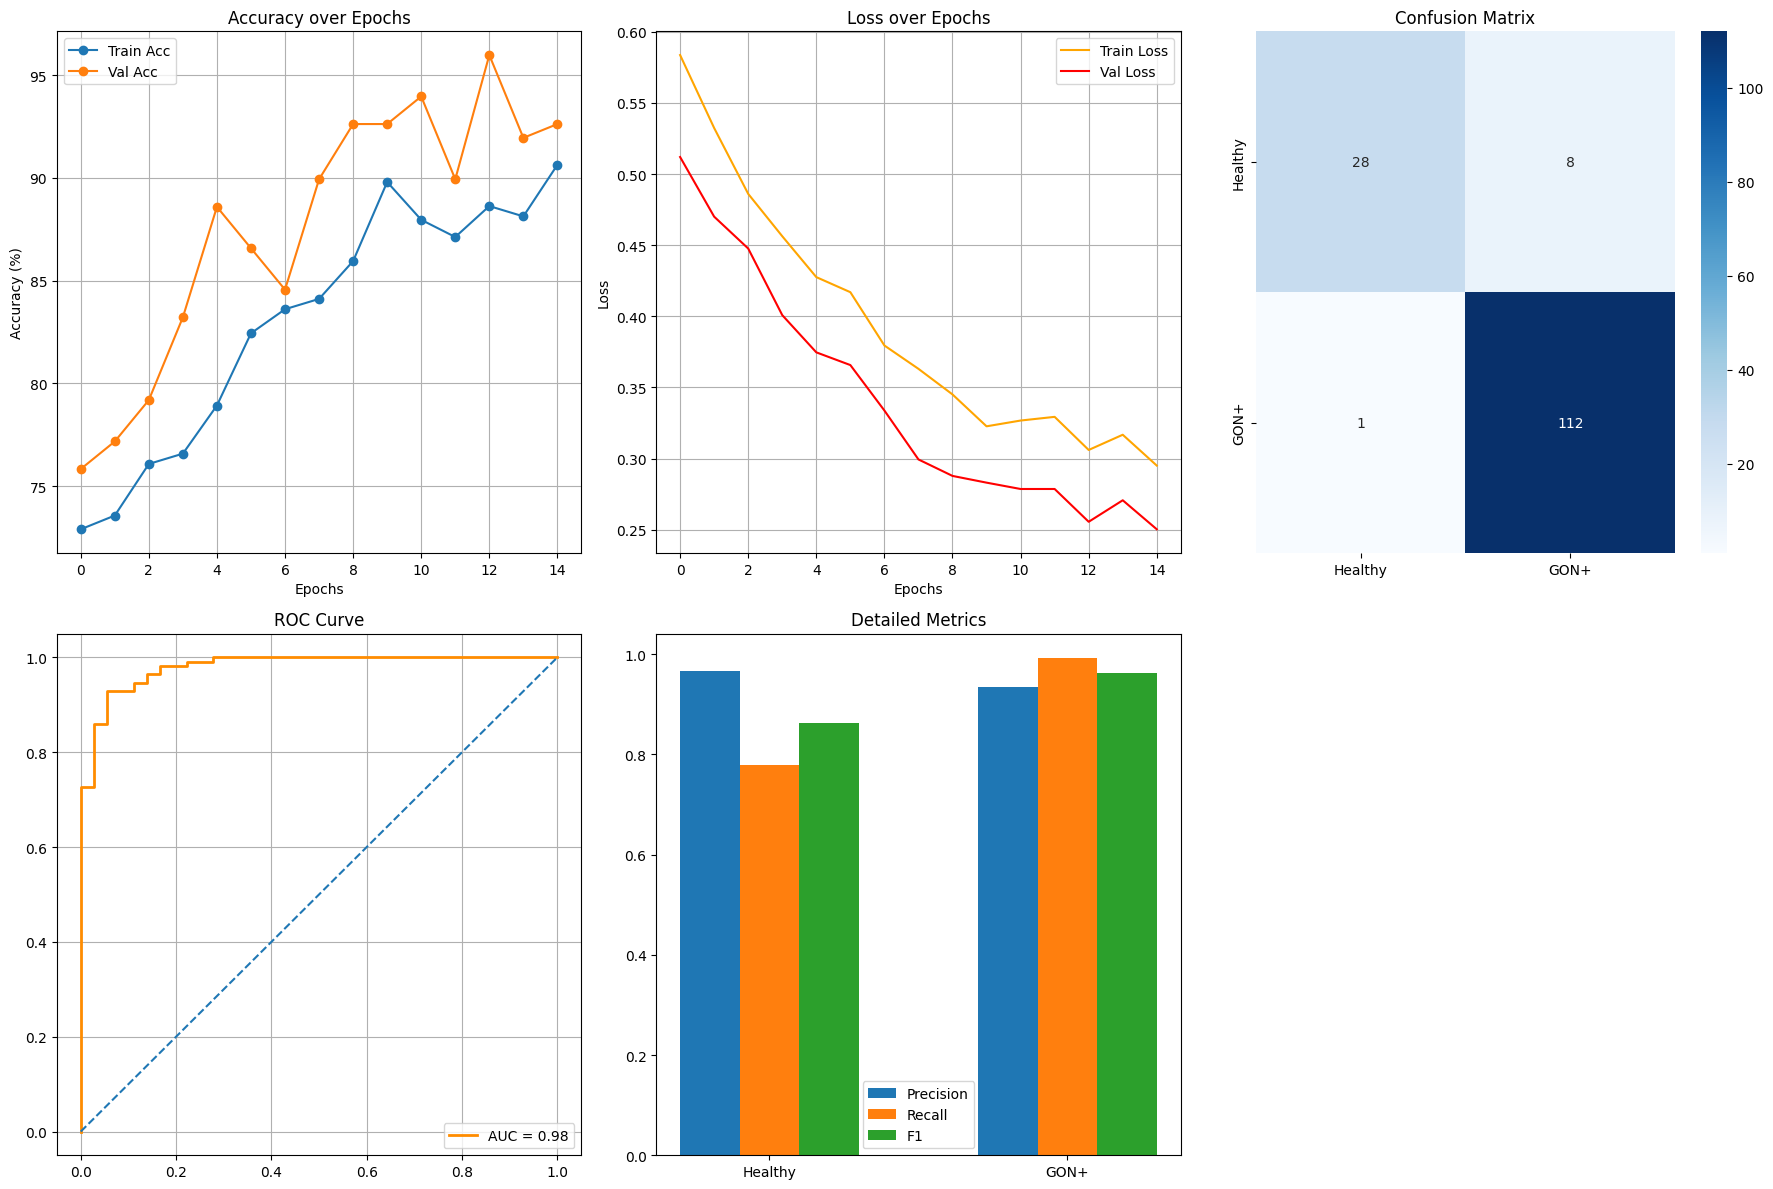


--- Detailed Classification Report ---
              precision    recall  f1-score   support

     Healthy       0.97      0.78      0.86        36
        GON+       0.93      0.99      0.96       113

    accuracy                           0.94       149
   macro avg       0.95      0.88      0.91       149
weighted avg       0.94      0.94      0.94       149



In [8]:
def show_comprehensive_report(history, model, loader, device):
    plt.figure(figsize=(18, 12))
    
    # 1. Accuracy Curve
    plt.subplot(2, 3, 1)
    plt.plot(history['train_acc'], label='Train Acc', marker='o')
    plt.plot(history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid()
    
    # 2. Loss Curve
    plt.subplot(2, 3, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='orange')
    plt.plot(history['val_loss'], label='Val Loss', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid()
    
    # Get Predictions for other metrics
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())

    # 3. Confusion Matrix
    plt.subplot(2, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'GON+'], yticklabels=['Healthy', 'GON+'])
    plt.title('Confusion Matrix')
    
    # 4. ROC-AUC Curve
    plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curve'); plt.legend(); plt.grid()

    # 5. Precision-Recall Bars
    plt.subplot(2, 3, 5)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    x = np.arange(2)
    plt.bar(x - 0.2, precision, 0.2, label='Precision')
    plt.bar(x, recall, 0.2, label='Recall')
    plt.bar(x + 0.2, f1, 0.2, label='F1')
    plt.xticks(x, ['Healthy', 'GON+'])
    plt.title('Detailed Metrics'); plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\n--- Detailed Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'GON+']))

# Show comprehensive report for the augmented model (best)
print("=== GENERATING DENSENET121 COMPREHENSIVE REPORT ===")
show_comprehensive_report(history_aug, model_densenet_aug, test_loader_aug, device)

CELL 8: PREDICTION VISUALIZATION

=== DENSENET121 EYE PREDICTIONS ===


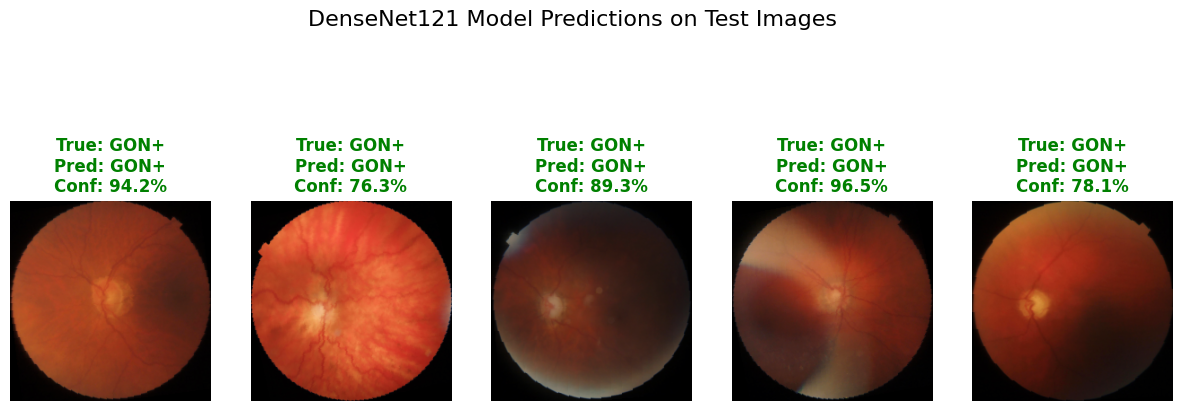

In [9]:
def visualize_densenet_predictions(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    # Get Predictions
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
    
    plt.figure(figsize=(15, 6))
    class_names = ['Healthy', 'GON+']
    
    for i in range(min(5, len(images))): 
        ax = plt.subplot(1, 5, i+1)
        
        # Denormalize image for display
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_lab = class_names[labels[i].item()]
        pred_lab = class_names[preds[i].item()]
        conf = confs[i].item() * 100
        
        # Color code: Green if correct, Red if wrong
        color = 'green' if true_lab == pred_lab else 'red'
        
        plt.title(f"True: {true_lab}\nPred: {pred_lab}\nConf: {conf:.1f}%", 
                  color=color, fontweight='bold')
        plt.axis('off')
        
    plt.suptitle("DenseNet121 Model Predictions on Test Images", fontsize=16)
    plt.show()

print("=== DENSENET121 EYE PREDICTIONS ===")
visualize_densenet_predictions(model_densenet_aug, test_loader_aug, device)

CELL 9: FINAL RESULTS COMPARISON

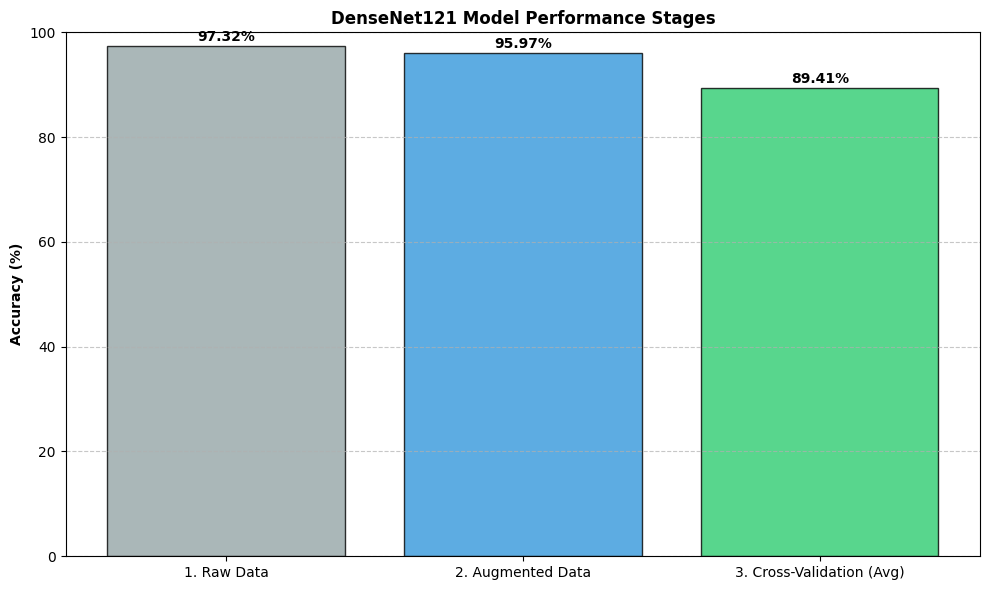

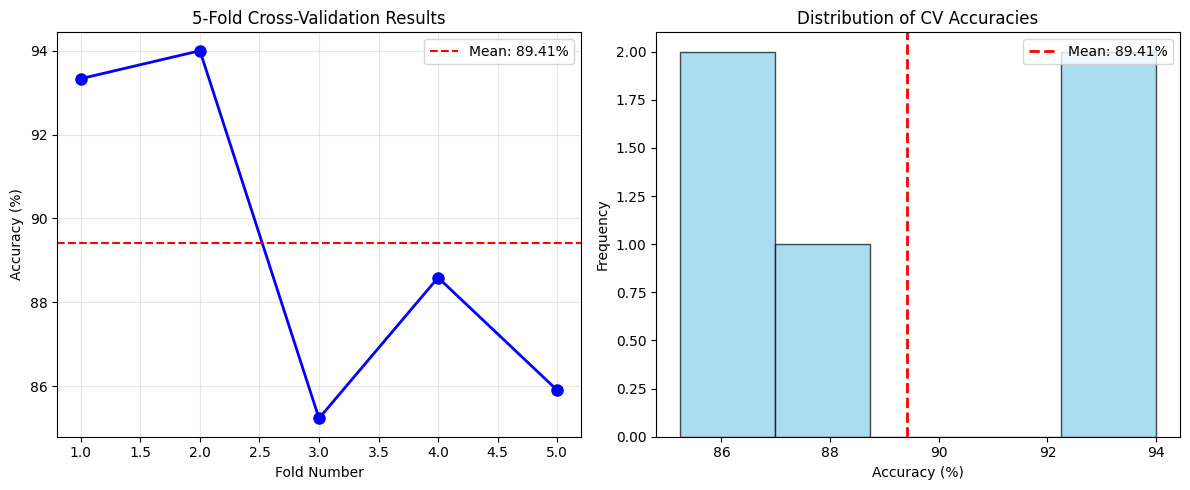


      DENSENET121 FINAL RESULTS SUMMARY      
1. Raw Data                    : 97.32%
2. Augmented Data              : 95.97%
3. Cross-Validation (Avg)      : 89.41%
CV Standard Deviation          : 3.66%
Best CV Fold                   : 94.00%
Worst CV Fold                  : 85.23%


In [10]:
# --- FINAL COMPARISON GRAPHS ---

# 1. Accuracy Comparison Bar Chart
plt.figure(figsize=(10, 6))
names = list(results.keys())
values = [v for v in results.values()]
colors = ['#95a5a6', '#3498db', '#2ecc71']

bars = plt.bar(names, values, color=colors, edgecolor='black', alpha=0.8)
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('DenseNet121 Model Performance Stages', fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Cross-Validation Analysis
if len(cv_accuracies) > 0:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), cv_accuracies, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=avg_cv_acc, color='red', linestyle='--', label=f'Mean: {avg_cv_acc:.2f}%')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy (%)')
    plt.title('5-Fold Cross-Validation Results')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(cv_accuracies, bins=5, color='skyblue', alpha=0.7, edgecolor='black')
    plt.axvline(x=avg_cv_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_cv_acc:.2f}%')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of CV Accuracies')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 3. Summary Report
print("\n" + "="*50)
print("      DENSENET121 FINAL RESULTS SUMMARY      ")
print("="*50)
for k, v in results.items():
    print(f"{k.ljust(30)} : {v:.2f}%")

if len(cv_accuracies) > 0:
    print(f"{'CV Standard Deviation'.ljust(30)} : {std_cv_acc:.2f}%")
    print(f"{'Best CV Fold'.ljust(30)} : {max(cv_accuracies):.2f}%")
    print(f"{'Worst CV Fold'.ljust(30)} : {min(cv_accuracies):.2f}%")
print("="*50)

CELL 10: SAVE BEST MODEL

In [11]:
# Save the best performing model (augmented version)
final_save_path = os.path.join(DATASET_ROOT, 'densenet121_final_best.pth')
torch.save(model_densenet_aug.state_dict(), final_save_path)

print(f"=== MODEL SAVED SUCCESSFULLY ===")
print(f"Best DenseNet121 Model Saved at: {final_save_path}")
print(f"Final Model Performance: {results['2. Augmented Data']:.2f}%")

# Also save model architecture info for loading later
model_info = {
    'model_name': 'DenseNet121',
    'num_classes': 2,
    'input_size': IMG_SIZE,
    'best_accuracy': results['2. Augmented Data'],
    'cv_mean_accuracy': avg_cv_acc if len(cv_accuracies) > 0 else 0.0,
    'preprocessing': 'ImageNet normalization + Augmentation'
}

import pickle
info_path = os.path.join(DATASET_ROOT, 'densenet121_model_info.pkl')
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)

print(f"Model info saved at: {info_path}")
print("\n=== TRAINING COMPLETE ===")
print("DenseNet121 model has been trained on Hillel Yaffe Glaucoma Dataset")
print("with raw data baseline, data augmentation, and 5-fold cross-validation.")

=== MODEL SAVED SUCCESSFULLY ===
Best DenseNet121 Model Saved at: C:\Projects\Thesis-Fall-25-26--G-606-main\densenet121_final_best.pth
Final Model Performance: 95.97%
Model info saved at: C:\Projects\Thesis-Fall-25-26--G-606-main\densenet121_model_info.pkl

=== TRAINING COMPLETE ===
DenseNet121 model has been trained on Hillel Yaffe Glaucoma Dataset
with raw data baseline, data augmentation, and 5-fold cross-validation.
